In [1]:
# Import libraries.
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Import data and view format of data.
wines_red_frame = pd.read_csv("winequality/winequality-red.csv", sep=";")
wines_white_frame = pd.read_csv("winequality/winequality-white.csv", sep=";")
wines_white_frame.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Above, we read in both red and white wine data sets. We also print out the white wine data just to see the different columns we have.

In [2]:
# Training and testing sets for white wine.
white_wine_Frame = wines_white_frame[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']]
white_wine_Matrix=white_wine_Frame.values

# Normalize the data
scaler_white = StandardScaler()
white_wine_Matrix = scaler_white.fit_transform(white_wine_Matrix)

white_train_indices, white_test_indices = train_test_split(white_wine_Matrix, test_size=0.2, shuffle=True)

X_white_train = white_train_indices[:, :-1] 
y_white_train = white_train_indices[:, -1]   
X_white_test = white_test_indices[:, :-1]     
y_white_test = white_test_indices[:, -1]       

# Training and testing sets for red wine.
red_wine_Frame = wines_red_frame[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']]
red_wine_Matrix=red_wine_Frame.values

#Normalize the data
scaler_red = StandardScaler()
red_wine_Matrix = scaler_red.fit_transform(red_wine_Matrix)

red_train_indices, red_test_indices = train_test_split(red_wine_Matrix, test_size=0.2, shuffle=True)

X_red_train = red_train_indices[:, :-1] 
y_red_train = red_train_indices[:, -1]   
X_red_test = red_test_indices[:, :-1]     
y_red_test = red_test_indices[:, -1] 

# Print sizes
print("X_train shape:", X_white_train.shape)
print("y_train shape:", y_white_train.shape)
print("X_test shape:", X_white_test.shape)
print("y_test shape:", y_white_test.shape)

print("X_train shape:", X_red_train.shape)
print("y_train shape:", y_red_train.shape)
print("X_test shape:", X_red_test.shape)
print("y_test shape:", y_red_test.shape)

X_train shape: (3918, 11)
y_train shape: (3918,)
X_test shape: (980, 11)
y_test shape: (980,)
X_train shape: (1279, 11)
y_train shape: (1279,)
X_test shape: (320, 11)
y_test shape: (320,)


In the code above we take the data frames for white and red wine and convert them into their respective matrices. Afterward we normalize the data (the results work alot better after we do this). We then split the data such that 20% of the data is used for testing and the rest is used for training. Data is randomly shuffled before we split. We then store these train and test data sets for both features and winequality into X and y. We print the resulting shapes

In [3]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1) 

    def forward(self, x):
        return self.linear(x)

In the code above we create the linear regression model using PyTorch.

In [4]:
def train_model(X_train, y_train, lambda_reg, epochs, learning_rate):
    model = LinearRegressionModel(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        l2 = 0
        for param in model.parameters():
            l2 += torch.norm(param)
        loss += lambda_reg * l2
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        #if(epoch+1)%50 == 0:
        #   print(f'Epoch [{epoch+1}/epochs], Loss: {loss.item():.4f}')
    return model, train_losses

The code above trains the linear regression model using SGD. We apply L2 regularization to prevent overfitting and track training loss through every epoch. There is a print statement towards the botom which prints result of every 50th epoch which was used for debugging.

In [5]:
def cross_validate(X_train, y_train, X_test, y_test, lambda_values, epochs, learning_rate):
    results = {}
    for lambda_regularization in lambda_values:
        model, train_losses = train_model(X_train, y_train, lambda_regularization, epochs, learning_rate)
        with torch.no_grad():
            model.eval()
            X_train_tensor = torch.FloatTensor(X_train)
            y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
            outputs = model(X_train_tensor)
            train_error = nn.MSELoss()(outputs, y_train_tensor).item()

        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test)
            y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
            test_outputs = model(X_test_tensor)
            test_error = nn.MSELoss()(test_outputs, y_test_tensor).item()
        
        results[lambda_regularization] = {'train_error': train_error,'test_error': test_error}
    return results

In the code above we run cross-validation on our linear regression model to evaluate its accuracy. The function loops over values of lambda, training the model, then returning the training and testing data using Mean Root Squared.

In [6]:
# Plotting
def plot_results(results, wine_type):
    lambda_vals = list(results.keys())
    
    train_errors = [results[lam]['train_error'] for lam in lambda_vals]
    test_errors = [results[lam]['test_error'] for lam in lambda_vals]

    plt.plot(lambda_vals, train_errors, marker='o', label='Training Error')
    plt.plot(lambda_vals, test_errors, marker='x', label='Testing Error')
    plt.xscale('log')
    plt.title(f'Training Errors and Testing Errors vs. λ for {wine_type} Wine')
    plt.xlabel('Regularization Parameter (λ)')
    plt.ylabel('Error (MSE)')
    plt.grid(True)
    plt.legend()
    plt.show()

The code above plots both training and testing errors for each lambda value in the array. Function was taken from ChatGPT for plotting.

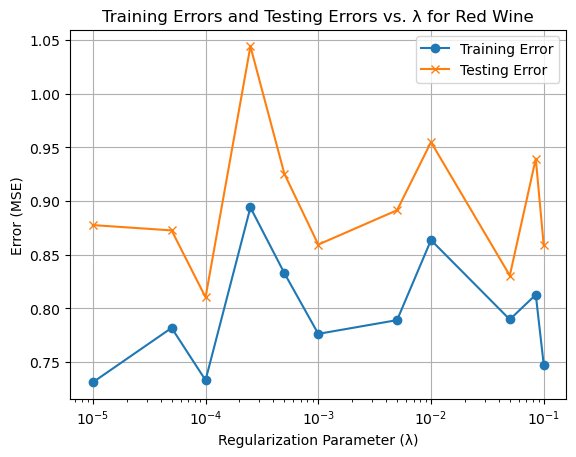

In [16]:
lambda_values = [.00001, .00005, 0.0001, .00025, .0005, 0.001, .005, .01, .05, .085, .1]
results_red = cross_validate(X_red_train, y_red_train, X_red_test, y_red_test, lambda_values, 2500, .0001)
plot_results(results_red, 'Red')

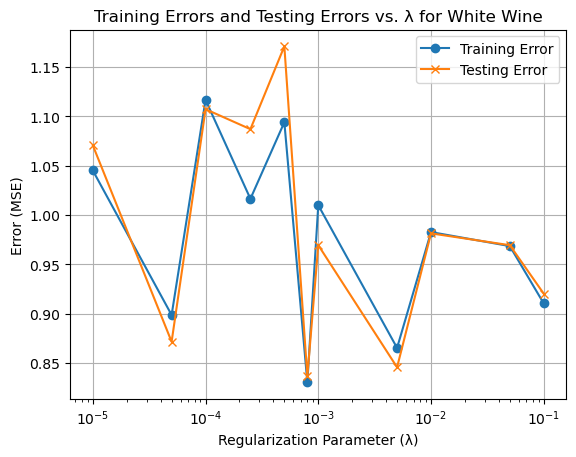

In [17]:
lambda_values = [.00001, .00005, 0.0001, .00025, .0005, .0008, 0.001, .005, .01, .05, .1]
results_white = cross_validate(X_white_train, y_white_train, X_white_test, y_white_test, lambda_values, 2000, .0001)
plot_results(results_white, 'White')

Above, we ran linear regression based on a multitude of lambda values on both white and red wine data. For both, it seems that there are different lambda values produce low testing errors.